# Framework Mapping with Deep Learning using Bidirectional Encoder Representations from Transformers (BERT)

Previously I designed a number of models using Naive-Bayes & Support Vector Machine algorithms which gave 40-60% accuracy.  The 60% accuracy for the SVM model would be acceptable and cut resource required for FW Mapping in half.  However,  after recent research I have found a number of methods which should, in theory, significantly out perform SVM and NB.  

The first of these methods is using BERT.
[(Research paper.)](https://)

BERT is a machine learning framework for Natural Language Processing that is open source (NLP). BERT is a programme that uses surrounding text to help computers grasp the meaning of ambiguous words in text. The BERT framework was trained using Wikipedia text and may be fine-tuned using question and answer datasets, or text classification datasets. 

BERT (Bidirectional Encoder Representations from Transformers) is based on Transformers, a deep learning model in which each output element is connected to each input element, and the weightings between them are dynamically calculated based on their connection. (This is referred to as attention in NLP.)

BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1

## Import Dependancies & Load Data

In [ ]:
!pip install transformers # install the transformer package

In [4]:
# import dependancies
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification


In [5]:
# load data
df = pd.read_csv("traindata.csv", encoding="Latin 1")
df.head()

,title,fwnum
0,Action Learning Set Courses,RM6145
1,Additions Plant & Machinry,RM6157
2,Additions Software,RM6068
3,Additns-Info Techno,RM6068
4,Adds - Assets Under Construc,RM6088


## Prepare Data

In [6]:
df["fwnum"].value_counts()

RM6068    470
RM3821    272
RM3830    265
RM6088    167
RM3822    151
         ... 
RM3858      1
RM3857      1
RM3856      1
RM3855      1
RM6100      1
Name: fwnum, Length: 156, dtype: int64

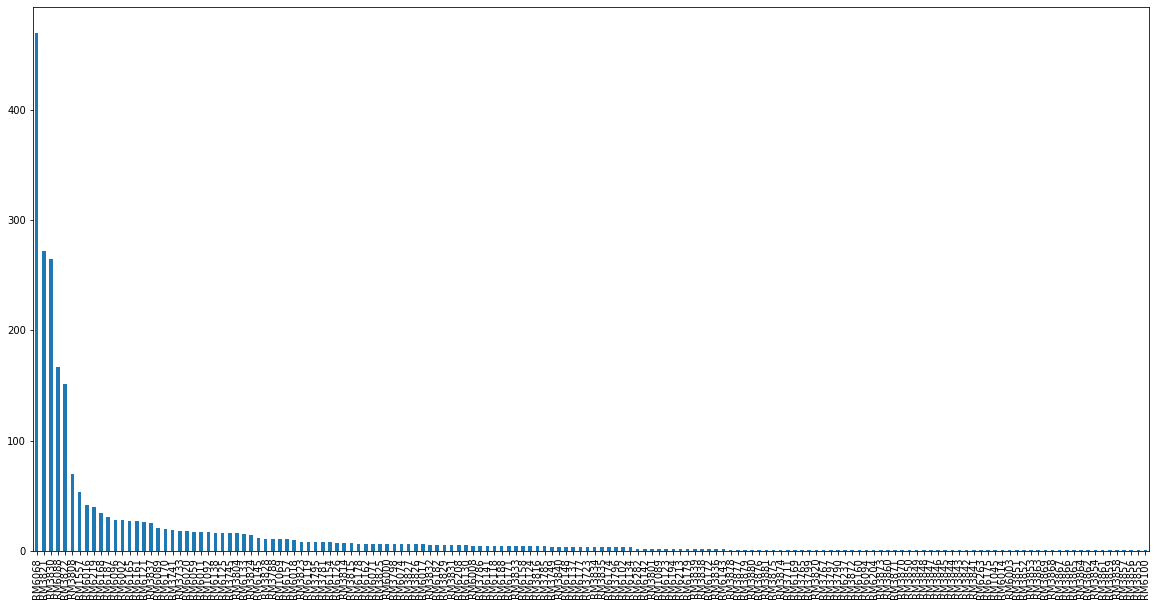

In [7]:
plt.figure(figsize=(20,10))
df.fwnum.value_counts().plot(kind='bar');

As we can see the classes (framework numbers) are imbalanced, this needs to be addressed. 

## Resampling

As we can see from the chart the dataset is highly imbalanced.  When the number of samples in each class is roughly equal, most machine learning methods operate well. Because most algorithms are designed to enhance accuracy while minimising errors.

However, if the data set is unbalanced, you can achieve a high level of accuracy simply by forecasting the majority class, but you will miss the minority class, which is usually the objective of developing the model in the first place. 

I can attempt to improve this by resampling.

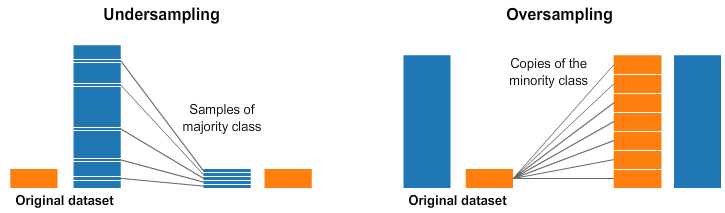

Despite the benefits of balancing classes, these methods are not without flaws ("there is no free lunch").

Over-sampling can be as simple as duplicating random records from the minority class, which can lead to overfishing.

The simplest method of under-sampling is to remove random records from the majority class, which can result in data loss.

**Random Under-Sampling:** The term "undersampling" refers to the practise of excluding some observations from the majority class. This is repeated until the majority and minority classes are evenly distributed.

When you have a lot of data, such as millions of rows, undersampling can be a viable option. However, one disadvantage of undersampling is that we are discarding potentially useful information.

**Random Over-Sampling:** Oversampling is defined as increasing the number of copies in the minority class. When you don't have a lot of data to work with, oversampling can be a smart option.

Undersampling has the disadvantage of causing overfitting and poor generalisation to your test set.

Fortunately the BERT has a inbuilt data stratification method which I will implement. 

Encoding the labels helps the model perform more accurately

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["label"] = le.fit_transform(df["fwnum"])

df


,title,fwnum,label
0,Action Learning Set Courses,RM6145,126
1,Additions Plant & Machinry,RM6157,129
2,Additions Software,RM6068,102
3,Additns-Info Techno,RM6068,102
4,Adds - Assets Under Construc,RM6088,105
...,...,...,...
2373,Security and Information Management,RM1557,4
2374,Cloud Infrastructure Consultancy,RM1557,4
2375,Acorn and Acorn Profiler software with Paychec...,RM1557,4
2376,"Support, Maintenance and upgrade costs for the...",RM1557,4


In [9]:
df = df.groupby("fwnum").filter(lambda x: len(x) >= 3)

df

,title,fwnum,label
0,Action Learning Set Courses,RM6145,126
1,Additions Plant & Machinry,RM6157,129
2,Additions Software,RM6068,102
3,Additns-Info Techno,RM6068,102
4,Adds - Assets Under Construc,RM6088,105
...,...,...,...
2373,Security and Information Management,RM1557,4
2374,Cloud Infrastructure Consultancy,RM1557,4
2375,Acorn and Acorn Profiler software with Paychec...,RM1557,4
2376,"Support, Maintenance and upgrade costs for the...",RM1557,4


## Split the Data & Stratify the Labels (resampling)

As the dataset is imbalanced it is required to use stratified sampling on the Framework Numbers.  

In [17]:
from sklearn.model_selection import train_test_split

X = df.index.values
y = df.label.values

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=y)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['title',"fwnum", 'label', 'data_type']).count()

,,,
title,fwnum,label,data_type
Criminal Justice Inspectorate Website Hosting and Support,RM1557,4,train
HMP & YOI Swinfen Hall - Conflict Resolution Training January 2020,RM3822,31,train
HMP Bristol Music Workshops,RM3822,31,train
HMP Ford Bricklaying,RM3822,31,train
HMP Highpoint Warehousing & Distributions 2020 / 2021,RM6074,104,train
...,...,...,...
new: 3D modelling software @ c. £5k,RM6068,102,val
prj_2888 - Provision of Data Links,RM3821,30,train
prj_4509 - HMP Whatton-Preperaton for release course- 2020,RM3840,49,train


## Tokenization

Tokenization is a process to take raw texts and split into tokens, which are numeric data to represent words.



*   Constructs a [BERT tokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer). Based on WordPiece.
*   Instantiate a pre-trained BERT model configuration to encode our data.
* To convert all the titles from text into encoded form, we use a function called batch_encode_plus , and we will proceed train and validation data separately.
* Instantiate a pre-trained BERT model configuration to encode our data.
* To convert all the titles from text into encoded form, we use a function called batch_encode_plus , and we will proceed train and validation data separately.
* The 1st parameter inside the above function is the title text.
* `add_special_tokens=True` means the sequences will be encoded with the special tokens relative to their model.
* When batching sequences together, we set `return_attention_mask=True`, so it will return the attention mask according to the specific tokenizer defined by the `max_length attribute`.
* We also want to pad all the titles to certain maximum length.
* We actually do not need to set `max_length=256`, but just to play it safe. `return_tensors='pt'` to return PyTorch.
* And then we need to split the data into `input_ids`, `attention_masks` and `labels`.
* Finally, after we get encoded data set, we can create training data and validation data.

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt')

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt')


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Model Building

We are treating each "title" or "description" as its unique sequence, so one sequence will be classified to one of the FW Number labels.

* `bert-base-uncased` is a smaller pre-trained model.
* Using `num_labels` to indicate the number of output labels.
* We don’t really care about `output_attentions`.
* We also don’t need `output_hidden_states`.

In [12]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(df["label"]),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Dataloading the Model
* `DataLoader` combines a dataset and a sampler, and provides an iterable over the given dataset.
* We use `RandomSampler` for training and `SequentialSampler` for validation.
* Given the limited memory in my environment, I set `batch_size=3`.

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 5

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

### Optimiser & Scheduler
We must supply an optimiser an iterable with the parameters to optimise before we can build it. The learning rate, epsilon, and other optimiser-specific variables can then be specified.

* I found `epochs=5` works well for this data set.
* Create a schedule with a learning rate that decreases linearly from the initial learning rate set in the optimiser to 0, after a warmup period during which it increases linearly from 0 to the initial learning rate set in the optimizer.

The AdamW is being depreciated in the next version of transformers,  this will be have to be updated in the future if model drift is detected. 

In [14]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 30

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### Performance Metrics
I will use f1 score and accuracy per class as performance metrics.

The F-measure is the harmonic mean of  precision and recall. In most situations, you have a trade-off between precision and recall. If you optimise your classifier to increase one and disfavor the other, the harmonic mean quickly decreases. It is greatest however, when both precision and recall are equal.

F-measures of 0.4 and 0.8 should be a sweet spot.

For visual reference take a look at this figure:

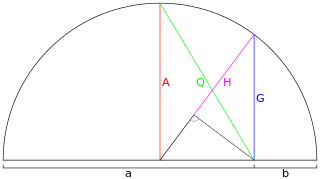

The F-measure is H, A and B are recall and precision. You can increase one, but then the other decreases.

In [15]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in df["label"].items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Training the Model



In [ ]:
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 1
Training loss: 5.983389331469419
Validation loss: 4.177619703437971
F1 Score (Weighted): 0.08416547709779126


Epoch 2:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 2
Training loss: 3.574584053062938
Validation loss: 3.1374839667392815
F1 Score (Weighted): 0.2639397479045247


Epoch 3:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 3
Training loss: 2.886046912754589
Validation loss: 2.7695130796536156
F1 Score (Weighted): 0.3184081977496167


Epoch 4:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 4
Training loss: 2.4928324769888004
Validation loss: 2.5698519490011362
F1 Score (Weighted): 0.3344356169245502


Epoch 5:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 5
Training loss: 2.1812058310011753
Validation loss: 2.47350329598007
F1 Score (Weighted): 0.34858406227078564


Epoch 6:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.9612082625036344
Validation loss: 2.4376113684038105
F1 Score (Weighted): 0.3518650609737683


Epoch 7:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.7789720223572014
Validation loss: 2.373867139139253
F1 Score (Weighted): 0.42226754347590223


Epoch 8:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.6217928093018097
Validation loss: 2.3870664323356166
F1 Score (Weighted): 0.4390806017492751


Epoch 9:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 9
Training loss: 1.4766482994752133
Validation loss: 2.3134068934570835
F1 Score (Weighted): 0.4669147658253975


Epoch 10:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 10
Training loss: 1.36762556314915
Validation loss: 2.302684036154381
F1 Score (Weighted): 0.4968286465897788


Epoch 11:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 11
Training loss: 1.258005958121544
Validation loss: 2.337600308743751
F1 Score (Weighted): 0.4933847878120733


Epoch 12:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 12
Training loss: 1.1682653452145388
Validation loss: 2.3208095353329554
F1 Score (Weighted): 0.5030946720396279


Epoch 13:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 13
Training loss: 1.0936650185736674
Validation loss: 2.3292992475857632
F1 Score (Weighted): 0.50611387412134


Epoch 14:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.9996480730232815
Validation loss: 2.280724020123117
F1 Score (Weighted): 0.5288703729712054


Epoch 15:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.9383679925202715
Validation loss: 2.3100515236197365
F1 Score (Weighted): 0.520787103929115


Epoch 16:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.8797861491317279
Validation loss: 2.3250630644565122
F1 Score (Weighted): 0.520781684399146


Epoch 17:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.8256523940377242
Validation loss: 2.3491209431769042
F1 Score (Weighted): 0.5311850895022154


Epoch 18:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.77834035906489
Validation loss: 2.3654187124541393
F1 Score (Weighted): 0.5309154853647763


Epoch 19:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.7405428034608691
Validation loss: 2.354274345189839
F1 Score (Weighted): 0.5389499090357674


Epoch 20:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.703718696842706
Validation loss: 2.3333648589120815
F1 Score (Weighted): 0.5385063182165499


Epoch 21:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.6699204866480011
Validation loss: 2.3992167562651248
F1 Score (Weighted): 0.5329864408347625


Epoch 22:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.6455166519401285
Validation loss: 2.3656370054156035
F1 Score (Weighted): 0.5313741290294979


Epoch 23:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.6175412215744158
Validation loss: 2.3672115594305545
F1 Score (Weighted): 0.5512195008350105


Epoch 24:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.5978592445868339
Validation loss: 2.3914563308113115
F1 Score (Weighted): 0.5445880754975544


Epoch 25:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.5763695841719846
Validation loss: 2.4002084840233335
F1 Score (Weighted): 0.5469354788940325


Epoch 26:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.5591792154851641
Validation loss: 2.3993274616077542
F1 Score (Weighted): 0.5490429984355872


Epoch 27:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.5509261867438751
Validation loss: 2.39701903212446
F1 Score (Weighted): 0.545960833846026


Epoch 28:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.5357477143616225
Validation loss: 2.404729942579845
F1 Score (Weighted): 0.5511419203001006


Epoch 29:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.5314035579341411
Validation loss: 2.4170192661315566
F1 Score (Weighted): 0.551397014507966


Epoch 30:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.5290065129897848
Validation loss: 2.4119258086417257
F1 Score (Weighted): 0.5536782784235672


Epoch 26, 28, 29 and 30 have the best metrics - I will load and evaluate model 30 and check it's classification accuracy. 

## Loading and Evaluating the Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(df["label"]),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load("finetuned_BERT_epoch_30.model", map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: 2078
Accuracy: 0/2

Class: 2013
Accuracy: 3/3

Class: 2377
Accuracy: 4/11

Class: 1752
Accuracy: 0/1

Class: 2106
Accuracy: 0/4

Class: 1922
Accuracy: 0/4

Class: 2084
Accuracy: 0/3

Class: 2021
Accuracy: 1/2

Class: 2007
Accuracy: 0/1

Class: 1707
Accuracy: 0/1

Class: 2016
Accuracy: 2/2

Class: 1884
Accuracy: 1/2

Class: 330
Accuracy: 0/1

Class: 2082
Accuracy: 0/1

Class: 2109
Accuracy: 0/3

Class: 2372
Accuracy: 9/14

Class: 2371
Accuracy: 0/1

Class: 2302
Accuracy: 0/1

Class: 2046
Accuracy: 0/1

Class: 2369
Accuracy: 25/54

Class: 1726
Accuracy: 27/30

Class: 1995
Accuracy: 0/2

Class: 2294
Accuracy: 1/3

Class: 1358
Accuracy: 0/1

Class: 1364
Accuracy: 0/1

Class: 1370
Accuracy: 0/1

Class: 2027
Accuracy: 0/2

Class: 1380
Accuracy: 0/1

Class: 2365
Accuracy: 43/53

Class: 1404
Accuracy: 0/1

Class: 1409
Accuracy: 0/1

Class: 1413
Accuracy: 0/1

Class: 1416
Accuracy: 0/1

Class: 1419
Accuracy: 0/1

Class: 2123
Accuracy: 5/5

Class: 1451
Accuracy: 0/1

Class: 1895
Accuracy:

The model performance isn't great,  but it is noted that it does score well on some classes.  Upon investigation the classes it performs well on seem to have one thing in common:  the contract title is quite informative.  

My next step is increasing the depth of content within the title feature.  I can then retrain and judge the model performance. 